# Generative Adversarial Networks GAN

https://realpython.com/generative-adversarial-networks/

Esse tutorial será todo desenvolvido em um ambiente virtual do anaconda, então para começar digite o comando abaixo:

`conda create --name gan`

`conda activate gan`

É preciso instalar o PyTorch, torchvision e matplotlib também. 

`conda install -c pytorch pytorch=1.4.0`

`conda install matplotlib jupyter`

`conda install -c pytorch torchvision=0.5.0`

Logo após é preciso registar o ambiente `gan` para usar corretamente os notebooks no nosso kernel. Para fazer isso, com o ambiente `gan`já ativado execute o comando:

`python -m ipykernel install --user --name gan`

In [1]:
# Importacao das bibliotecas
import torch
from torch import nn

import math
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms


In [ ]:
torch.manual_seed(42)

In [4]:
device = ""
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(device)

cuda


In [5]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])


In [6]:
train_set = torchvision.datasets.MNIST(root=".", train=True, download=True, transform=transform)


Extracting .\MNIST\raw\train-images-idx3-ubyte.gz to .\MNIST\raw


Extracting .\MNIST\raw\train-labels-idx1-ubyte.gz to .\MNIST\raw


Extracting .\MNIST\raw\t10k-images-idx3-ubyte.gz to .\MNIST\raw


Extracting .\MNIST\raw\t10k-labels-idx1-ubyte.gz to .\MNIST\raw
Processing...
Done!


In [7]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)

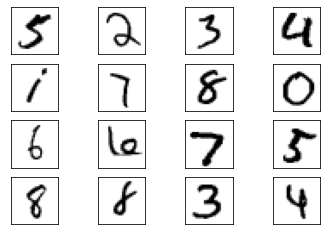

In [8]:
real_samples, mnist_labels = next(iter(train_loader))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(real_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])


### Implementado o Discriminator

No PyTorch, os modelos de redes neurais são representados por classes através no `nn.Module`, então nós iremos definir a classe Discriminator. Essa classe é um modelo com 784 dimensões de entrada (28x28 pixels) e uma dimensão de saída. Irá receber uma amostra real da nosso dataset ou a partir do Generator e irá calcular a probabilidade dassa amostra pertencer ao dataset real de treinamento. 

Iremos usar `.__ init __()` para construir o modelo. Primeiro, você precisa chamar `super() .__ init __()` para executar `.__ init __()` do `nn.Module`. O discriminador que você está usando é uma rede neural MLP definida de forma sequencial usando `nn.Sequential()`. 

Por último usa-se `.forward()` para descrever como a saída do modelo. Nessa função, x representa a entrada do modelo, que é um tensor com 784 dimensões. Nesta implementação, a saída é obtida alimentando a entrada x para o modelo que definiu-se sem qualquer outro processamento.


Sua estrutura é:


In [10]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(x.size(0), 784)
        output = self.model(x)
        return output
    
discriminator = Discriminator().to(device=device)

In [11]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 512),

            nn.ReLU(),
            nn.Linear(512, 1024),

            nn.ReLU(),
            nn.Linear(1024, 784),

            nn.Tanh(),
        )


    def forward(self, x):
        output = self.model(x)
        output = output.view(x.size(0), 1, 28, 28)
        return output


generator = Generator().to(device=device)

In [12]:
lr = 0.0001
num_epochs = 50
loss_function = nn.BCELoss()

optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)


In [13]:
for epoch in range(num_epochs):
    for n, (real_samples, mnist_labels) in enumerate(train_loader):
        # Data for training the discriminator
        real_samples = real_samples.to(device=device)
        real_samples_labels = torch.ones((batch_size, 1)).to(device=device)

        latent_space_samples = torch.randn((batch_size, 100)).to(device=device)

        generated_samples = generator(latent_space_samples)

        generated_samples_labels = torch.zeros((batch_size, 1)).to(device=device)

        all_samples = torch.cat((real_samples, generated_samples))

        all_samples_labels = torch.cat((real_samples_labels, generated_samples_labels))


        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()


        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, 100)).to(device=device)


        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(output_discriminator_generated, real_samples_labels)
        loss_generator.backward()
        optimizer_generator.step()


        # Show loss
        if n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")

Epoch: 0 Loss D.: 0.5272714495658875
Epoch: 0 Loss G.: 0.5387742519378662
Epoch: 1 Loss D.: 0.04208478331565857
Epoch: 1 Loss G.: 4.928516864776611
Epoch: 2 Loss D.: 0.005358031485229731
Epoch: 2 Loss G.: 6.618221759796143
Epoch: 3 Loss D.: 0.057121895253658295
Epoch: 3 Loss G.: 5.916602611541748
Epoch: 4 Loss D.: 0.06895875930786133
Epoch: 4 Loss G.: 5.817418575286865
Epoch: 5 Loss D.: 0.3430798351764679
Epoch: 5 Loss G.: 4.145073413848877
Epoch: 6 Loss D.: 0.11150267720222473
Epoch: 6 Loss G.: 3.325338840484619
Epoch: 7 Loss D.: 0.16606274247169495
Epoch: 7 Loss G.: 2.360994338989258
Epoch: 8 Loss D.: 0.21820616722106934
Epoch: 8 Loss G.: 2.0405054092407227
Epoch: 9 Loss D.: 0.2811850309371948
Epoch: 9 Loss G.: 2.22027587890625
Epoch: 10 Loss D.: 0.40277138352394104
Epoch: 10 Loss G.: 1.767693281173706
Epoch: 11 Loss D.: 0.3420459032058716
Epoch: 11 Loss G.: 1.4313760995864868
Epoch: 12 Loss D.: 0.3155617117881775
Epoch: 12 Loss G.: 1.4871972799301147
Epoch: 13 Loss D.: 0.30071234703

In [14]:
latent_space_samples = torch.randn(batch_size, 100).to(device=device)
generated_samples = generator(latent_space_samples)


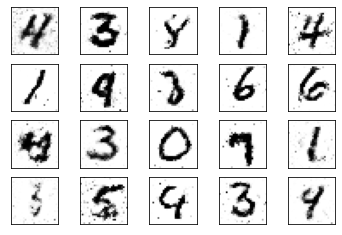

In [21]:
generated_samples = generated_samples.cpu().detach()
for i in range(20):
    ax = plt.subplot(4, 5, i + 1)
    plt.imshow(generated_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])
